In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [32]:
class GridWorld:
    def __init__(self, size=4, terminal_states=((0, 0), (3, 3)), reward=-1):
        self.size = size
        self.state_space = size * size
        self.terminal_states = terminal_states
        self.reward = reward
        self.actions = ("U", "D", "L", "R")
        self.action_space = len(self.actions)
        self.reset()

    def is_terminal(self, state):
        return state in self.terminal_states

    def reset(self):
        self.state = (np.random.randint(self.size), np.random.randint(self.size))
        while self.state in self.terminal_states:
            self.state = (np.random.randint(self.size), np.random.randint(self.size))
        return self.state

    def step(self, action):
        if self.is_terminal(self.state):
            return self.state, 0, True

        x, y = self.state
        if action == "U":
            x = max(x - 1, 0)
        if action == "D":
            x = min(x + 1, self.size - 1)
        if action == "L":
            y = max(y - 1, 0)
        if action == "R":
            y = min(y + 1, self.size - 1)
        self.state = (x, y)

        return self.state, self.reward, self.is_terminal(self.state)


def eps_greedy_policy(env, state, Q, eps):
    if np.random.random() < eps:
        return np.random.choice(env.actions)

    q_values = Q[state[0], state[1], :]
    best_action_idx = np.argmax(q_values)
    return env.actions[best_action_idx]

In [ ]:
def plot_value_function(Q, env, size=4, episode=0):
    V = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            state = (i, j)
            state_action_values = [Q[i, j, env.actions.index(a)] for a in env.actions]
            if state_action_values:
                V[i, j] = max(state_action_values)

    plt.figure(figsize=(6, 6))
    plt.imshow(V, cmap="coolwarm", interpolation="nearest")
    for i in range(size):
        for j in range(size):
            plt.text(j, i, f"{V[i, j]:.1f}", ha="center", va="center", color="black")
    plt.title(f"State Value Function (Episode {episode})")
    plt.colorbar()
    plt.show()

In [34]:
def q_learning(
    env,
    num_episodes=500,
    gamma=1.0,
    alpha=0.1,
    eps_start=1.0,
    eps_decay=0.99,
    eps_min=0.01,
):
    Q = np.zeros((env.size, env.size, env.action_space))

    episodes_steps = []

    eps = eps_start
    for _ in tqdm(range(num_episodes)):
        state = env.reset()
        num_steps = 0

        while True:
            action = eps_greedy_policy(env, state, Q, eps)
            next_state, reward, done = env.step(action)
            num_steps += 1

            if done:
                target = reward - Q[state[0], state[1], env.actions.index(action)]

                Q[state[0], state[1], env.actions.index(action)] += alpha * target
                break
            else:
                target = reward + gamma * np.max(Q[next_state[0], next_state[1], :])
                td_error = target - Q[state[0], state[1], env.actions.index(action)]

                Q[state[0], state[1], env.actions.index(action)] += alpha * td_error

            state = next_state

        episodes_steps.append(num_steps)
        eps = max(eps * eps_decay, eps_min)

    return Q, episodes_steps

100%|██████████| 10000/10000 [00:00<00:00, 62947.67it/s]


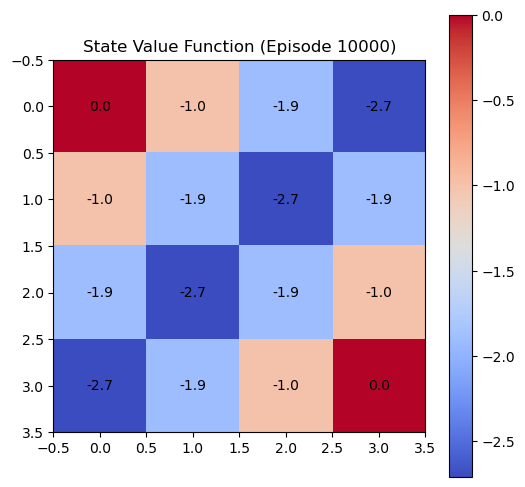

In [47]:
N = 10_000

env = GridWorld()

Q, episodes_steps = q_learning(
    env=env,
    num_episodes=N,
    gamma=0.9,
    alpha=0.1,
    eps_start=1.0,
    eps_decay=0.995,
    eps_min=0.01,
)
plot_value_function(Q, env, env.size, N)

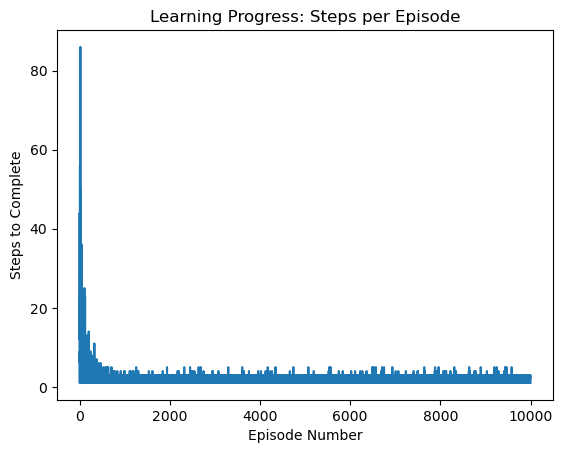

In [48]:
plt.plot(list(range(len(episodes_steps))), episodes_steps)
plt.title('Learning Progress: Steps per Episode')
plt.xlabel('Episode Number')
plt.ylabel('Steps to Complete')
plt.show()